Assignment 1:

Name: Nishad Wajge

UID: 119578728

Please submit to Gradescope
- a PDF containing all outputs (by executing **Run all**).
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: Nishad Wajge


There are both coding problems and write-up problems in this assignment.

For coding problems, implement functions and scripts where you see a `TODO` or parts with points.

For write-ups, make sure you answer all the questions.

# Part A: Image Colorization (55 Points)

## Overview

The goal of Part A is to reconstruct a full-color image from the digitized Prokudin-Gorskii glass plate photographs, which consist of three grayscale images captured through red, green, and blue filters. These three channel images are vertically stacked in a single image and are slightly misaligned due to camera movement and subject motion during exposure.

To produce a visually coherent color image, the three color channels must first be extracted and then precisely aligned with one another before being combined into a single RGB image. The primary challenge lies in accurately aligning the channels so as to minimize visual artifacts. This alignment is performed by searching over possible displacements and selecting the one that maximizes a similarity metric between channels, such as Sum of Squared Differences (SSD) or Normalized Cross-Correlation (NCC). Once the optimal alignment is found, the channels are stacked to form the final color image.


NOTE:

1. Reading [this](https://www.loc.gov/exhibits/empire/making.html) for more background information and samples.

2. You can use any image processing libraries of your choice such as skimage or cv2; in python.


You are required to provide **THREE colorized image results**. Choose ONE of the results, and use it to provide answers in the write-up.

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
!unzip "/content/hybrid_pyramid_input.zip" -d "/content/"

!gdown 19_UNxJ6zAH5-4-ljo-OvnuLKWhtkaChO
!unzip "/content/parta_data.zip" -d "/content/parta_data"

Downloading...
From: https://drive.google.com/uc?id=1KTDxPAkQam29YKtoX5dKPnLKpUOWCanC
To: /content/hybrid_pyramid_input.zip
100% 2.19M/2.19M [00:00<00:00, 146MB/s]
Archive:  /content/hybrid_pyramid_input.zip
replace /content/data/Afghan_girl_before.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
print(os.listdir('/content/data'))

##A.0 Know your data (20 pts)



### Read and show images **(10 pts)**
Let's start with some helper functions. Implement helper functions below so you can read and visualize images.

In [ ]:
# Import necessary packages here
import numpy as np
from PIL import Image

# Helper Functions
def read_image_pil(image_path: str) -> Image:
    """
    :param image_path: path to the image
    :return: representation of the image
    """
    # TODO: YOUR CODE HERE (10 pts)
    # Read an image using PIL.Image.open()
    image = Image.open(image_path)
    return image


In [ ]:
# Check if you can read and show an image. You are free to change path.
image_path = '/content/data/cat.bmp'
image_pil = read_image_pil(image_path)
# PIL image can be directly shown by just calling it.
image_pil

We can do conversions between PIL image format and numpy array. Try commands below.

In [ ]:
print(image_pil)  # show the data type of an PIL image
image_np = np.array(image_pil) # PIL image -> numpy array
print('Image shape: ', image_np.shape) # show the shape
print('Data type: ', image_np.dtype) # show the data type
print(image_np) # show exact pixel values
image_pil_new = Image.fromarray(image_np) # numpy array -> PIL image
print(image_pil_new)

There are also other ways to show an image. For example, you can also use `matplotlib.pyplot`. Run the code below and get yourself familiar with it.

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image_np)
plt.show()

###Write-up (10 pts)
1. What is the difference between a `PIL` image and an image as a `numpy.array`? **(5 pt)**
2. What is the data type of an image by default it is directly converted from a `PIL` image? What is the value range?  **(5 pts)**

**Include your write-up here**
1. The difference is that a PIL image is an object that has metadata like format size, channels, etc.. A numpy array represents the image as a tensor of pixel values. PIL images have specific operations such as resize, rotate, and save, whereas numpy arrays have math ops like multiplication, slicing, and analysis. PIL is good for file I/O and numpy is best for manipulating pixel values.
2. The value type for PIL is uint8, with a value range from 0 to 255.

##A.1 Implementation of Image Colorization (35 pts)



###Data type **(5 pts)**
In practice, we need to convert the data type into `float` so that we can apply mathmatical operations. We first write `read_image` function below. Let's use `float64` in this assignment.

In [ ]:
def read_image(image_path: str) -> np.ndarray:
    """
    :param image_path: path to the image
    :return: floating representation of the image. Use np.float64.
    """
    # TODO: YOUR CODE HERE (10 pts)
    image = np.array(Image.open(image_path), dtype=np.float64) / 255.0
    return image

Let's check if you are doing it right. The value range should be in [0.0, 1.0].

In [ ]:
image_path = '/content/parta_data/00125v.jpg'
img = read_image(image_path)
print(img.shape)
print(img.dtype)
print('value range: [{}, {}]'.format(img.min(), img.max()))

###Helper Functions

In [ ]:
def read_and_split_image(image_path: str) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    NO NEED TO CHANGE THIS FUNCTION.
    Reads an image and splits it into its RGB channels.
    :param image_path: path to the image
    :return: R, G, B data
    """
    # read in the image
    im = read_image(image_path)
    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    # separate color channels
    b = im[:height]
    g = im[height:2 * height]
    r = im[2 * height:3 * height]

    return r, g, b

def center_crop(img: np.ndarray, frac: float = 0.5) -> np.ndarray:
    """
    NO NEED TO CHANGE THIS FUNCTION.
    Return the centered crop of an image. frac=0.5 keep the central 50% in both height and width.
    :param img: image array
    :return: cropped image
    """
    h, w = img.shape
    ch, cw = int(h * frac), int(w * frac)
    top = (h - ch) // 2
    left = (w - cw) // 2
    return img[top:top+ch, left:left+cw]

###Normalized Cross-Correlation (NCC) (5 pts)

NCC measures the similarity between two images while being robust to differences in brightness and contrast. Since the Prokudin-Gorskii color channels were captured using different filters and exposure conditions, raw pixel differences can be misleading. NCC addresses this by normalizing both images to zero mean and unit variance before computing their similarity.

Given two image patches A and B, NCC is computed as:
$$NCC(A,B)= \frac{1}{N} \sum ( \frac{A-\mu_A}{\sigma_a})( \frac{B-\mu_B}{\sigma_B}) \ $$

In [ ]:
def normalized_cross_correlation(img1: np.ndarray, img2: np.ndarray) -> float:
    """
    Compute the normalized cross-correlation (NCC) between two arrays.
    :param img1, img2: image array
    :return score
    """
    # TODO: YOUR CODE HERE (5 pts)
    # Step 1: get the norm of each image
    img1_norm = np.linalg.norm(img1)
    img2_norm = np.linalg.norm(img2)

    # Step 1: compute ncc score from two normalized images
    ncc = np.sum(img1 * img2) / (img1_norm * img2_norm)

    return ncc

In [ ]:
# Sanity check

img = np.random.randn(100, 100)
score = normalized_cross_correlation(img, img)
assert score > 0.99, score

###Image Alignment (5 pts)

This function aligns one image to a reference image by exhaustively searching over a fixed window of possible shifts. For each candidate displacement, the moving image is shifted, and NCC is computed over the center crop. The displacement that yields the highest NCC score is selected.

In [ ]:
def align_images(mov: np.ndarray, ref: np.ndarray, max_shift: int = 32) -> tuple[int, int]:
    """
    Align mov to ref by searching over a window of shifts and maximizing NCC.

    :param ref: reference image (e.g., blue channel)
    :param mov: moving image (e.g., red or green channel)
    :param max_shift: maximum pixel displacement in each direction
    :return: (dx, dy) shift that best aligns mov to ref
    """

    best_dx, best_dy = 0, 0
    best_score = -np.inf

    ref_c = center_crop(ref)

    # TODO: YOUR CODE HERE (5 pts)
    for dx in range(-max_shift, max_shift + 1):
        for dy in range(-max_shift, max_shift + 1):
            # Shift mov by (dx, dy), hint: use np.roll
            shifted_mov_x = np.roll(mov, shift=dx, axis=1) # Shift mov by dx in x dim
            shifted_mov = np.roll(shifted_mov_x, shift=dy, axis=0) # Shift shifted_mov_x by dy in y dim

            # Compute NCC on the centered image to avoid edge effects
            shifted_c = center_crop(shifted_mov) # get the centered shifted_mov
            score = normalized_cross_correlation(shifted_c, ref_c)

            # Update best shift
            if score > best_score:
                best_score = score
                best_dx, best_dy = dx, dy

    return best_dx, best_dy

In [ ]:
# Sanity check
np.random.seed(0)
ref = np.random.randn(120, 160)
true_dx, true_dy = 8, -5
mov = np.roll(ref, true_dx, axis=1)
mov = np.roll(mov, true_dy, axis=0)

dx, dy = align_images(ref, mov, max_shift=15)
assert (dx, dy) == (true_dx, true_dy), (dx, dy)


### Image Colorization (10 pts)
It's time to officially implement Image Colorization.

Let's wrap up all the stuff in a single function `image_colorization`. The key idea is to choose one channel as the reference, then align the remaining two channels to this reference using the alignment function implemented earlier. In the provided hint code, the blue channel is used as the reference, but you are encouraged to experiment with using the red or green channel instead and compare the visual results.

After computing the optimal shifts, apply them to align the channels. Finally, stack the aligned red, green, and blue channels together to form the reconstructed RGB color image.


In [ ]:
def image_colorization(image_path: str):
    """
    :param image_path: path to the image
    :return: Colorized image
    """
    r, g, b = read_and_split_image(image_path)

    # TODO: YOUR CODE HERE (5 pts)
    # Step 1: get the best shifts
    dx_r, dy_r = align_images(r, b) # shift red channel take blue channel as reference
    dx_g, dy_g = align_images(g, b) # shift green channel take blue channel as reference

    # Step 2: apply the shifts, hint: use np.roll
    r_shifted = np.roll(np.roll(r, dx_r, axis=1), dy_r, axis=0)
    g_shifted = np.roll(np.roll(g, dx_g, axis=1), dy_g, axis=0)
    b_shifted = b

    # Step 3: create a color image, hint: use np.stack
    color_img = np.stack((r_shifted, g_shifted, b_shifted), axis=-1)

    return color_img

Let's see if we are doing it right. You should see the colorized image like [This](https://drive.google.com/file/d/1qSLrMnNfwoQKOPXrhDhW-y7HYQ2kz-F6/view?usp=sharing).

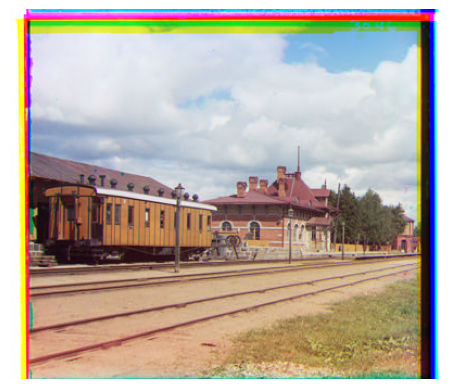

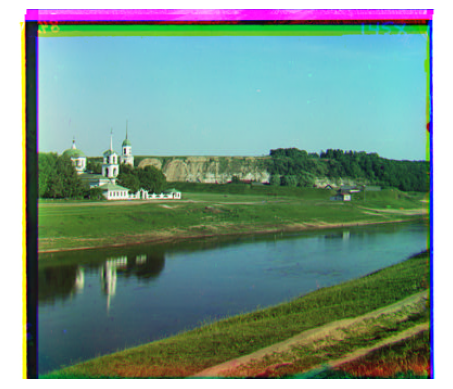

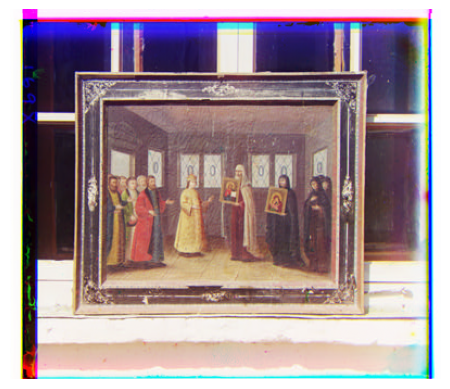

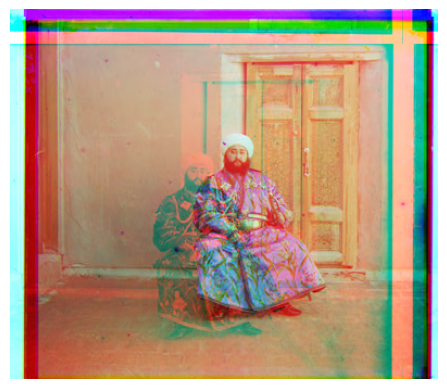

In [17]:
imgs = ['/content/parta_data/00398v.jpg', '/content/parta_data/00125v.jpg', '/content/parta_data/00149v.jpg', '/content/parta_data/00153v.jpg']

for img in imgs:
  colorized_img = image_colorization(img)

  # Display the image
  plt.imshow(colorized_img)
  plt.axis('off')
  plt.show()

### Write-up (10 pts)


1.   Run `image_colorization` on 3 different images. Report your results below. (5 pts)
4.   Briefly explain how this works, using your favorite results as illustrations. (5 pt)

**Include your write-up here**
1.
2. First you take black and white photos but through a red, green, and blue filter. Because they were taken in different times, they would be slightly misaligned, so they needed to be realigned. So, we assume the blue is the anchor, and shift based on some window the other two layers. For each shift, we generate a NCC between the two images, and select the highest one for each with the blue to overlay and create the final RGB image.

# Part B: Hybrid Image (45 Points)

## Overview

A hybrid image is the sum of a *low-pass filtered* version of the one image and a *high-pass filtered* version of a second image. There is a free parameter, which can be tuned for each image pair, which controls how much high frequency to remove from the first image and how much low frequency to leave in the second image. This is called the “cutoff-frequency”. In the paper it is suggested to use two cutoff frequencies (one tuned for each image) and you are free to try that, as well. In the starter code, the cutoff frequency is controlled by changing the standard deviation of the Gausian filter used in constructing the hybrid images. [This](https://drive.google.com/uc?id=187FjBJLwnYXhylx08Vdh1SAA3AO-imYv) is the sample example.

NOTE:

1. Reading [this](https://stanford.edu/class/ee367/reading/OlivaTorralb_Hybrid_Siggraph06.pdf) will help in understanding Part B.

2. You can use any image processing libraries of your choice such as skimage or cv2; in python.

We provided 7 pairs of aligned images. The alignment is important because it affects the perceptual grouping (read the paper for details). We encourage you to create additional examples (e.g. change of expression, morph between different objects, change over time, etc.).

You are required to provide **THREE hybrid image results**. Choose ONE of the results, and use it to provide answers in the write-up.

##B.1 Implementation of Hybrid Image (55 pts)
Now let's start to implement hybrid image. We will start again with some helper functions.

###Helper Functions

In [18]:
def vis_hybrid_image(hybrid_image) -> np.ndarray:
  """
  NO NEED TO CHANGE THIS FUNCTION.
  Visualize a hybrid image by progressively downsampling the image and
  concatenating all of the images together.
  :param hybrid_image:
  :return:
  """
  scales = 5
  scale_factor = 0.5
  padding = 5
  original_height = hybrid_image.shape[0]
  num_colors = hybrid_image.shape[2] # counting how many color channels the input has
  output = hybrid_image
  cur_image = hybrid_image

  for i in range(2, scales):
      # add padding
      output = np.concatenate((output, np.ones((original_height, padding, num_colors), dtype=int)), axis=1)
      # dowsample image;
      width = int(cur_image.shape[1] * scale_factor)
      height = int(cur_image.shape[0] * scale_factor)
      dim = (width, height)
      cur_image = cv2.resize(cur_image, dim, interpolation = cv2.INTER_LINEAR)
      # pad the top and append to the output
      tmp = np.concatenate((np.ones((original_height-cur_image.shape[0], cur_image.shape[1], num_colors)), cur_image), axis=0)
      output = np.concatenate((output, tmp), axis=1)

  output = (output * 255).astype(np.uint8)
  return output

###2D Gaussian filters **(15 pts)**
We will implement a 2D Gaussian filter function in `gaussian_2D_filter`. **(12 pts)**

Recall from our lectures that a 2D Gaussian filter is a matrix/tensor filled with values, represented as:
$$G(x,y)= \frac{1}{2 \pi \sigma^2} \exp^{-\frac{x^2 + y^2}{2 \sigma^2}} \,,$$
where $x$ and  $y$  denote the distances from the origin along the horizontal and vertical axes, respectively, and  $\sigma$  represents the standard deviation, which controls the extent of the blur or "cut-off frequency".



Hint 1: You probably want to get those coordinates $(x,y)$ so that you can compute values at each pixel. In practice, it is easier to get the coordinates of pixels with `np.meshgrid`. Check out an example [here](https://numpy.org/doc/2.1/reference/generated/numpy.meshgrid.html) (See Examples).  

Hint 2: In `numpy`, most of the functions are element-wise, meaning they apply the same operation to every element in an array, e.g., `np.exp`.

To apply a filter to an image, implement `imgfilter`. You can use `scipy.signal.convolve2d` (check out an example [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)) .**(3 pts)**

In [19]:
import cv2
from scipy.signal import convolve2d

def gaussian_2D_filter(size: tuple[int, int], sigma: int) -> np.ndarray:
    """
    :param size: tuple (width, height) that decides the filter size
    :param sigma: standard deviation, hyperparameter to control the variance of the filter
    :return: 2D gaussian filter with the desired size, and variance scaled by cutoff_frequency
    Hint: make sure the filter sums up to one
    Do NOT use scipy's API to get the filter. Please just use numpy to implement the Gaussian equation.
    """
    # TODO: YOUR CODE HERE (5 pts)
    # Step 1: Make a mesh grid using `np.meshgrid`. (Why?)
    w, h = size
    x_range = np.linspace(-(w - 1) / 2, (w - 1) / 2, w)
    y_range = np.linspace(-(h - 1) / 2, (h - 1) / 2, h)
    x_map, y_map = np.meshgrid(x_range, y_range)

    # Step 2: Compute Gaussian function with `np.exp` and the mesh grid.
    kernel = np.exp(-(x_map**2 + y_map**2) / (2 * sigma**2))

    # Step 3: Normalize so that sum equals 1
    filter = kernel / np.sum(kernel)

    return filter

def imgfilter(image: np.ndarray, filter: np.ndarray, conv_mode='same', boundary='symm') -> np.ndarray:
    """
    Apply a 2D filter to an image using convolution. Supports both grayscale and RGB images.

    :param image: input image (grayscale or RGB) to apply the filter on
    :param filter: the filter to apply on the image
    :param conv_mode: 'same' or 'valid'
    :param boundary: 'symm', 'reflect', or 'wrap'
    :return: apply the filter by convolving
    Do NOT use for loops. See how to convolve with scipy.signal.convolve2d.
    """
    # TODO: YOUR CODE HERE (5 pts)

    # Step 1: check if it is a grayscale image or a RGB image.


    # Step 2: apply the filter to it

    if image.ndim == 2:
        output = convolve2d(image, filter, mode=conv_mode, boundary=boundary)
        return output

    elif image.ndim == 3:
        r = image[:, :, 0]
        g = image[:, :, 1]
        b = image[:, :, 2]

        # Convolve each channel independently
        r_filtered = convolve2d(r, filter, mode=conv_mode, boundary=boundary)
        g_filtered = convolve2d(g, filter, mode=conv_mode, boundary=boundary)
        b_filtered = convolve2d(b, filter, mode=conv_mode, boundary=boundary)

        # Stack them back together into a 3D image
        output = np.stack([r_filtered, g_filtered, b_filtered], axis=-1)
        return output

    else:
        raise ValueError("is not rgb or greyscale")


    return output


(25, 25)
Sum of the filter should be 1:  1.0


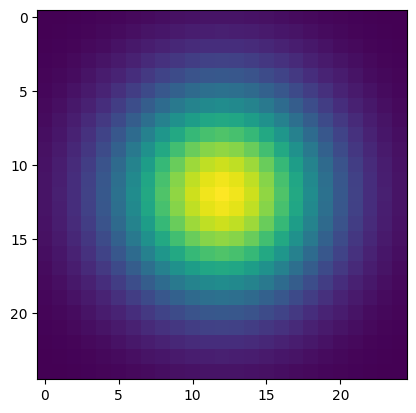

In [20]:
# Sanity check
filter_example = gaussian_2D_filter((25, 25), sigma=5.0)
print(filter_example.shape)
print('Sum of the filter should be 1: ', filter_example.sum())

# Visualize it
plt.imshow(filter_example)
plt.show()

###Visualize FFT (10 pts)
After applying a Gaussian filter, high-frequency component is reduced. A way to check one's frequency domain is to use Fast Fourier Transform (FFT). Let's now implement `log_mag_FFT` function below.

In [21]:
def log_mag_FFT(image: np.ndarray) -> np.ndarray:
    """
    :param image: float matrix representation of the image
    :return: log of the magnitude of the FFT of the image
    HINT: You may use np.log(np.abs(np.fft.fftshift(np.fft.fft2(image)))) to achieve it.
    NOTE1: numpy fft2 would require you to convert the image to grayscale for it to work properly.
    NOTE2: To make grayscale, you may use either `grey = R*0.3 + G*0.59 + B*0.11` or `cv2.cvtColor`.
    """
    # TODO: YOUR CODE HERE

    # Step 1: convert an image to grayscale if needed.
    if image.ndim == 3:
        r = image[:, :, 0]
        g = image[:, :, 1]
        b = image[:, :, 2]

        grey_image = 0.3 * r + 0.59 * g + 0.11 * b

    else:
        grey_image = image

    # Step 2: compute log magnitute.
    fft = np.fft.fftshift(np.fft.fft2(grey_image))
    mag = np.abs(fft)
    output = np.log(mag)

    return output

Let's see how we have done so far. Below we read an image, create and apply a Gaussian filter to it, and visualize the log magnitute of the FFT.

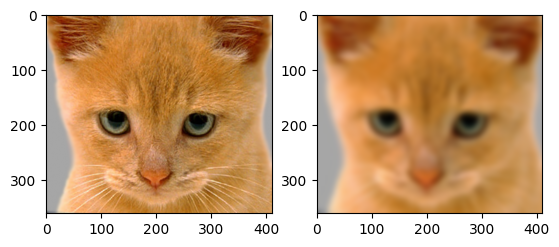

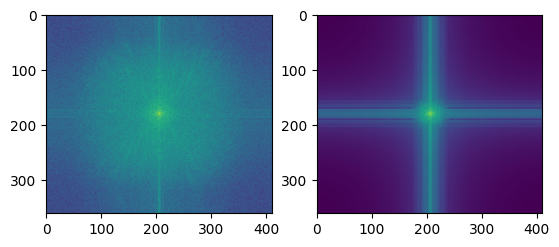

In [22]:
# Read an image
img_path = '/content/data/cat.bmp'
img = read_image(img_path)

# make a Gaussian filter. Feel free to modify parameters.
filter_size = 25
sigma = 5.0
gaussian_filter = gaussian_2D_filter((filter_size, filter_size), sigma)

# apply the filter
img_low_freq = imgfilter(img, gaussian_filter)

# visualize images (before and after, side by side)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(img_low_freq)
plt.show()

# visualize the FFT (before and after, side by side)
plt.subplot(1, 2, 1)
plt.imshow(log_mag_FFT(img))
plt.subplot(1, 2, 2)
plt.imshow(log_mag_FFT(img_low_freq))
plt.show()


### Hybrid image (10 pts)
It's time to officially implement Hybrid Image. You're expected to compose two images together.

Let's wrap up all the stuff in a single function `hybrid_image`.


In [23]:
from re import I
# Finish hybrid_image.
def hybrid_image(image1: np.ndarray, image2: np.ndarray, sigma_low_freq: int, sigma_high_freq: int, if_visual=False):
    """
    :param image1: image of type float64
    :param image2: image of type float64
    :param sigma_low_freq: Standard deviation for the low-pass filter (image1)
    :param sigma_high_freq: Standard deviation for the high-pass filter (image2)
    :return: Hybrid image combining low-frequency and high-frequency content
    """

    # Determine filter size based on sigma (typically 6*sigma covers most of the Gaussian)
    filter_size_low = (int(6 * sigma_low_freq) | 1, int(6 * sigma_low_freq) | 1)
    filter_size_high = (int(6 * sigma_high_freq) | 1, int(6 * sigma_high_freq) | 1)

    ###### TODO START #######
    # TODO 1: Finish hybrid image.
    # Step 1: Create Gaussian filters
    low_pass_filter = gaussian_2D_filter(filter_size_low, sigma_low_freq)
    high_pass_filter = gaussian_2D_filter(filter_size_high, sigma_high_freq)

    # Step 2: Apply low-pass filter to image1
    low_frequencies = imgfilter(image1, low_pass_filter)

    # Step 3: Apply low-pass filter to image2 and subtract from original to get high frequencies
    low_from_image2 = imgfilter(image2, high_pass_filter)
    high_frequencies = image2 - low_from_image2

    # Step 4: Combine the two components
    hybrid = low_frequencies + high_frequencies

    # Step 5: clip output value range. See np.clip().
    output = np.clip(hybrid, 0, 1)

    ###### TODO END ######

    if if_visual:
      # Visualization code. NO NEED TO CHANGE.
      # visualize two input images, sigma_low_freq, sigma_high_freq, and the hybrid image.
      fig, axs = plt.subplots(2, 5, figsize=(20, 10))
      axs[0, 0].imshow(image1)
      axs[0, 1].imshow(low_frequencies)
      axs[0, 2].imshow(image2)
      axs[0, 3].imshow(high_frequencies + 0.5)
      axs[0, 4].imshow(output)

      # visualize log magnitude of Fourier Transform of the above.
      axs[1, 0].imshow(log_mag_FFT(image1), vmin=0, vmax=10)
      axs[1, 1].imshow(log_mag_FFT(low_frequencies), vmin=0, vmax=10)
      axs[1, 2].imshow(log_mag_FFT(image2), vmin=0, vmax=10)
      axs[1, 3].imshow(log_mag_FFT(high_frequencies), vmin=0, vmax=10)
      axs[1, 4].imshow(log_mag_FFT(output), vmin=0, vmax=10)

      axs[0, 0].set_title('Image 1')
      axs[0, 1].set_title('Low-freq of Image 1')
      axs[0, 2].set_title('Image 2')
      axs[0, 3].set_title('High-freq of Image 2')
      axs[0, 4].set_title('Hybrid image')
      axs[1, 0].set_title('FFT of Image 1')
      axs[1, 1].set_title('FFT of Low-freq Image 1')
      axs[1, 2].set_title('FFT of Image 2')
      axs[1, 3].set_title('FFT of High-freq Image 2')
      axs[1, 4].set_title('FFT of Hybrid image')
      #plt.subplots_adjust(hspace=0)
      fig.tight_layout()
      plt.show()

      # visualize hybrid_image_scale using helper function vis_hybrid_image.
      fig, ax = plt.subplots(figsize=(20, 10))
      ax.imshow(vis_hybrid_image(output))
      plt.show()



    return output  # Ensure valid pixel range for floating point images (0-1)

Let's see if we are doing it right. You should see a hybrid image of a dog and a cat.

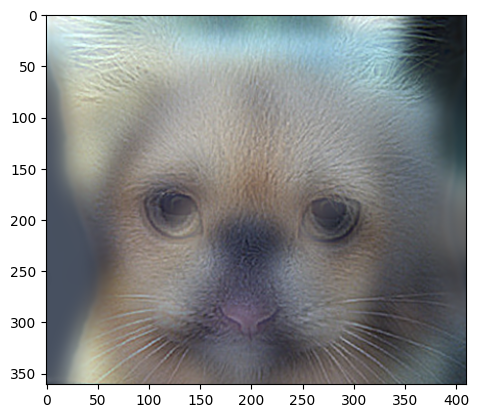

In [24]:
# read two images
image_path1 = '/content/data/dog.bmp'
image_path2 = '/content/data/cat.bmp'
image1 = read_image(image_path1)
image2 = read_image(image_path2)

# do hybrid image
hybrid_output = hybrid_image(image1, image2, sigma_low_freq=10, sigma_high_freq=2, if_visual=False)

# show output
plt.imshow(hybrid_output)
plt.show()

### Write-up (10 pts)


1.   Run `hybrid_image` on 3 different combinations. Report your results below. (5 pts) NOTE: You should always compose images that have the same shape.
3.   What happened to the FFTs? Anything changed? Explain what you have found. (2 pts)
4.   Briefly explain how this works, using your favorite results as illustrations. (3 pt)

**Include your write-up here**
1. [Above]
2. For the low frequency image, the FFT of the image is concentrated around the borders which is black because the normal blur removes the sharp details of the image. In the high frequency image, it is the opposite and the center is dark. The hybrid is just the sum of these two, and you can see the bright clusters and spread out patterns from both respective images.
3. The way this work is based on the human visual system. From close up, humans can see find detail, high frequencies in this case. So the edges and lines dominate perception. From far away, your eyes blur the granular details and instead have blobs of shapes and shadows.

# Save as a PDF file
Make sure you have run Dependecies below. It will take a while.
You will find PDF file on your left hand side.
If the following code does not work for you, go `File > Print > Save`.

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

You will be prompted to allow permissions to Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/CMSC426-Spring25/assignments/CMSC426_Assignment1_sp26.ipynb ./
!jupyter nbconvert --to PDF "CMSC426_Assignment1_sp26.ipynb"
